In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

import scipy.stats as stats
import pymc as pm
import arviz as az

from sklearn.preprocessing import StandardScaler

sns.set_style("whitegrid")

In [2]:
print(pm.__version__)
print(az.__version__)

5.7.2
0.16.1


In [3]:
df1 = pd.read_csv('data_01.csv')
df2 = pd.read_csv('data_02.csv')
df3 = pd.read_csv('data_03.csv')
df4 = pd.read_csv('data_04.csv')
df5 = pd.read_csv('data_05.csv')
df6 = pd.read_csv('data_06.csv')

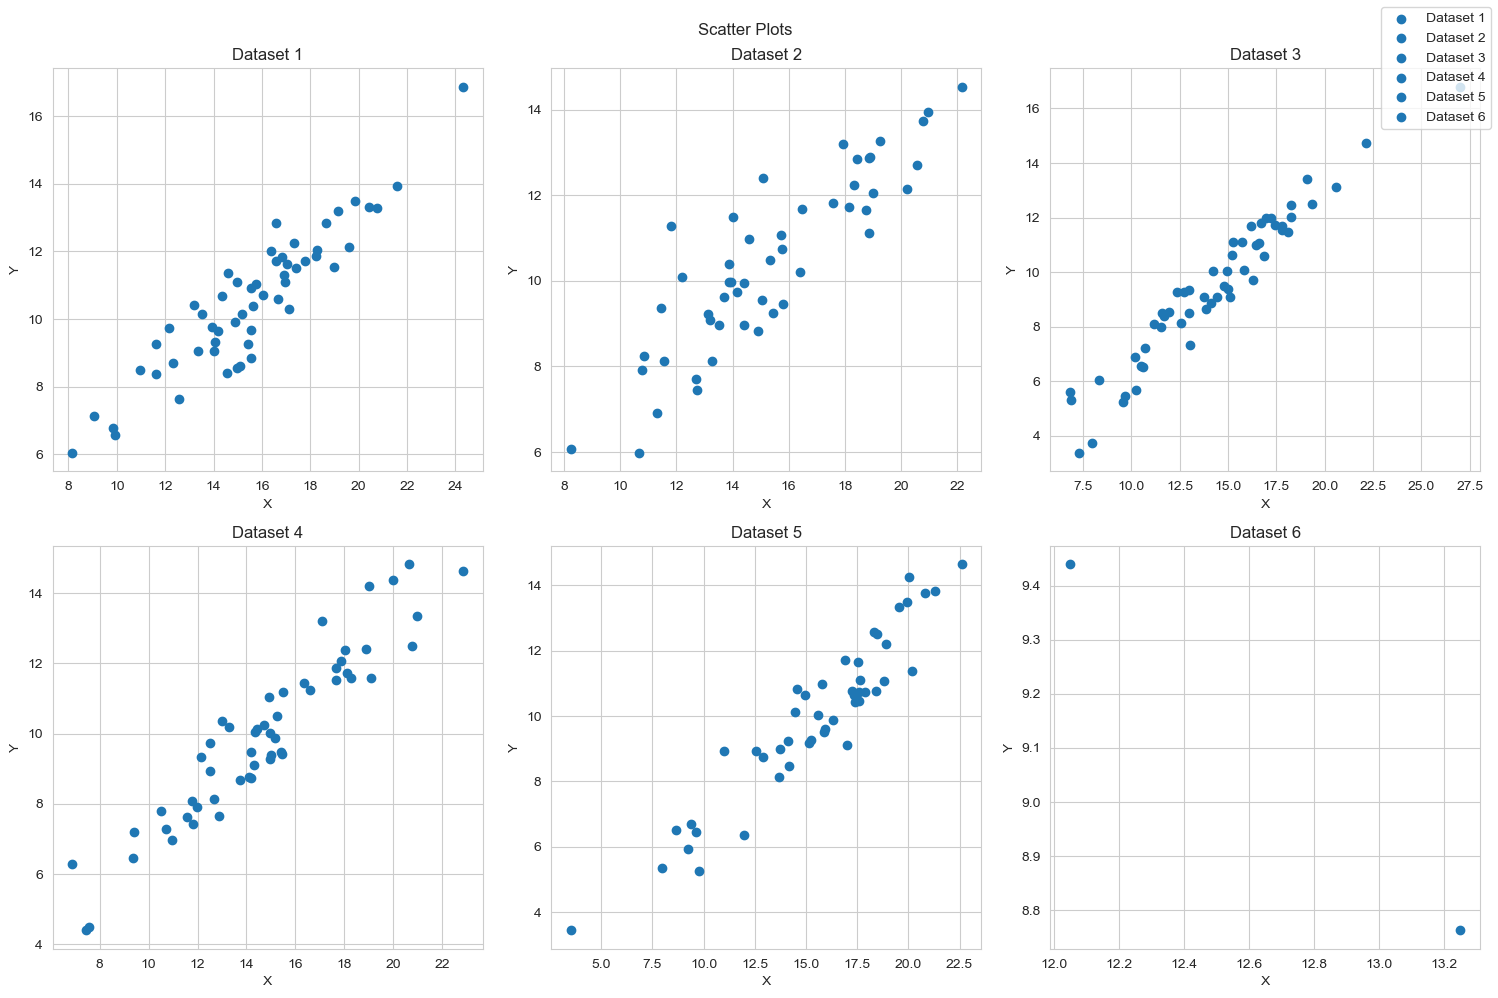

In [4]:
datasets = [df1, df2, df3, df4, df5, df6]

titles = ['Dataset 1', 'Dataset 2', 'Dataset 3', 'Dataset 4', 'Dataset 5', 'Dataset 6']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, dataset in enumerate(datasets):

    x = dataset.x
    y = dataset.y


    ax = axes[i // 3, i % 3]

    # Постройте скаттерплот
    ax.scatter(x, y, label=titles[i])
    ax.set_title(titles[i])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')


fig.suptitle('Scatter Plots')
fig.legend(loc='upper right')
axes[1, 2].axis('on')  
plt.tight_layout()
plt.show()

In [5]:
datasets = [df1, df2, df3, df4, df5, df6]
x_data = [df['x'].values for df in datasets]
y_data = [df['y'].values for df in datasets]

In [6]:
datasets = [df1, df2, df3, df4, df5, df6]
all_data = pd.concat(datasets, keys=range(len(datasets)))
all_data['dataset_idx'] = np.repeat(range(len(datasets)), [len(df) for df in datasets])
all_data['x_s'] = all_data.x - all_data.x.mean()
all_data = all_data.rename(columns = {'x':'x_old','x_s':'x'})

# threshold = 2 
# all_data = all_data[(all_data['y'] >= all_data['y'].mean() - threshold * all_data['y'].std()) &
#                                     (all_data['y'] <= all_data['y'].mean() + threshold * all_data['y'].std())]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_tmp, β, ε, ν]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


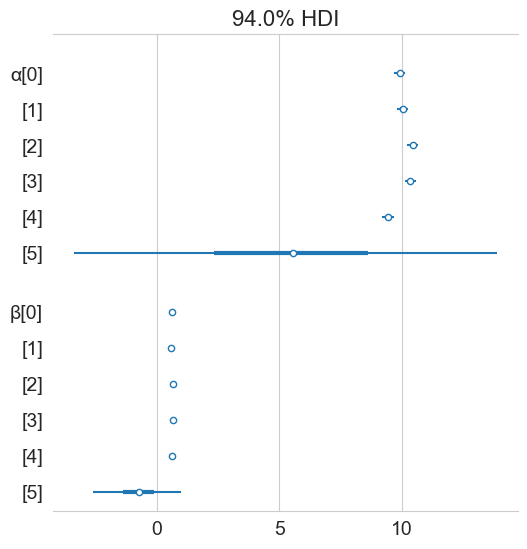

In [7]:
M = len(datasets)
N = len(all_data)

with pm.Model() as unpooled_model:
    α_tmp = pm.Normal('α_tmp', mu=0, sigma=10, shape=M)
    β = pm.Normal('β', mu=0, sigma=10, shape=M)
    ε = pm.HalfCauchy('ε', 5)
    ν = pm.Exponential('ν', 1/30)

    y_pred = pm.StudentT('y_pred', mu=α_tmp[all_data['dataset_idx']] + β[all_data['dataset_idx']] * all_data['x'].values,
                         sigma=ε, nu=ν, observed=all_data['y'].values)

    α = pm.Deterministic('α', α_tmp - β * all_data.groupby('dataset_idx').mean()['x'].values)

    trace_up = pm.sample(1000, chains=4, cores = 4, target_accept=0.95)

az.plot_forest(trace_up, var_names=['α', 'β'], combined=True);


In [8]:
az.summary(trace_up)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α_tmp[0],10.228,0.112,10.011,10.426,0.001,0.001,5635.0,2942.0,1.0
α_tmp[1],10.234,0.123,10.012,10.472,0.002,0.001,5036.0,2613.0,1.0
α_tmp[2],9.945,0.112,9.729,10.151,0.002,0.001,5245.0,3063.0,1.0
α_tmp[3],10.143,0.117,9.929,10.366,0.002,0.001,5615.0,2861.0,1.0
α_tmp[4],9.713,0.122,9.484,9.947,0.001,0.001,7079.0,2692.0,1.0
α_tmp[5],7.307,2.370,2.885,11.775,0.040,0.029,3519.0,2962.0,1.0
β[0],0.589,0.035,0.522,0.654,0.000,0.000,5876.0,2885.0,1.0
β[1],0.569,0.037,0.502,0.640,0.001,0.000,5167.0,2532.0,1.0
β[2],0.658,0.029,0.603,0.711,0.000,0.000,5465.0,2511.0,1.0
β[3],0.631,0.034,0.567,0.692,0.000,0.000,5417.0,2543.0,1.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α_μ_tmp, α_σ_tmp, β_μ, β_σ, α_tmp, β, ε, ν]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.


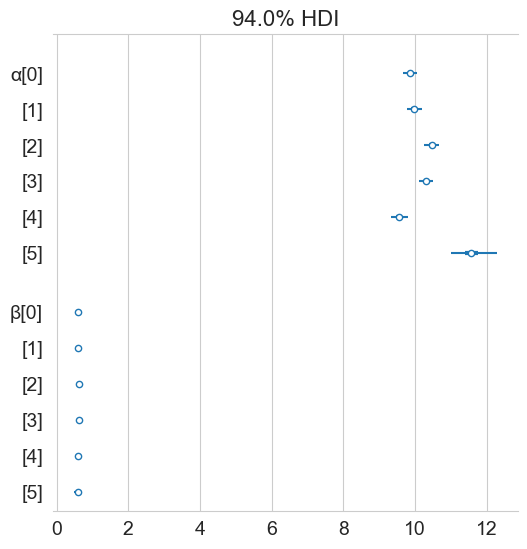

In [9]:
with pm.Model() as hierarchical_model:
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0, sigma=5)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', sigma=3)
    β_μ = pm.Normal('β_μ', mu=0, sigma=1)
    β_σ = pm.HalfNormal('β_σ', sigma=1)

    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sigma=α_σ_tmp, shape=len(datasets))
    β = pm.Normal('β', mu=β_μ, sigma=β_σ, shape=len(datasets))
    ε = pm.HalfCauchy('ε', 3)   
    ν = pm.Exponential('ν', 1/12)


    y_pred = pm.StudentT('y_pred', mu=α_tmp[all_data['dataset_idx']] + β[all_data['dataset_idx']] * all_data['x'].values,
                         sigma=ε, nu=ν, observed=all_data['y'].values)

    α = pm.Deterministic('α', α_tmp - β * all_data.groupby('dataset_idx').mean()['x'].values)
    α_μ = pm.Deterministic('α_μ', α_μ_tmp - β_μ * all_data.groupby('dataset_idx').mean()['x'].values)
    α_σ = pm.Deterministic('α_sd', α_σ_tmp - β_μ * all_data.groupby('dataset_idx').mean()['x'].values)

    trace_hm = pm.sample(1000,  chains=4, cores = 4, target_accept=0.95)

# Отобразите результаты
az.plot_forest(trace_hm, var_names=['α', 'β'], combined=True);


In [10]:
az.summary(trace_hm)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α_μ_tmp,10.058,0.155,9.801,10.372,0.005,0.003,1497.0,1040.0,1.0
β_μ,0.608,0.031,0.550,0.662,0.001,0.001,1543.0,1346.0,1.0
α_tmp[0],10.180,0.106,9.987,10.382,0.002,0.001,3187.0,2808.0,1.0
α_tmp[1],10.169,0.112,9.964,10.375,0.002,0.001,2782.0,2727.0,1.0
α_tmp[2],9.969,0.103,9.772,10.157,0.002,0.001,3524.0,3140.0,1.0
α_tmp[3],10.111,0.103,9.921,10.306,0.002,0.001,4134.0,2692.0,1.0
α_tmp[4],9.811,0.132,9.580,10.068,0.003,0.002,2013.0,2641.0,1.0
α_tmp[5],10.148,0.275,9.664,10.748,0.007,0.005,1940.0,1362.0,1.0
β[0],0.601,0.027,0.550,0.653,0.001,0.000,2487.0,2155.0,1.0
β[1],0.593,0.029,0.534,0.643,0.001,0.000,2312.0,2882.0,1.0


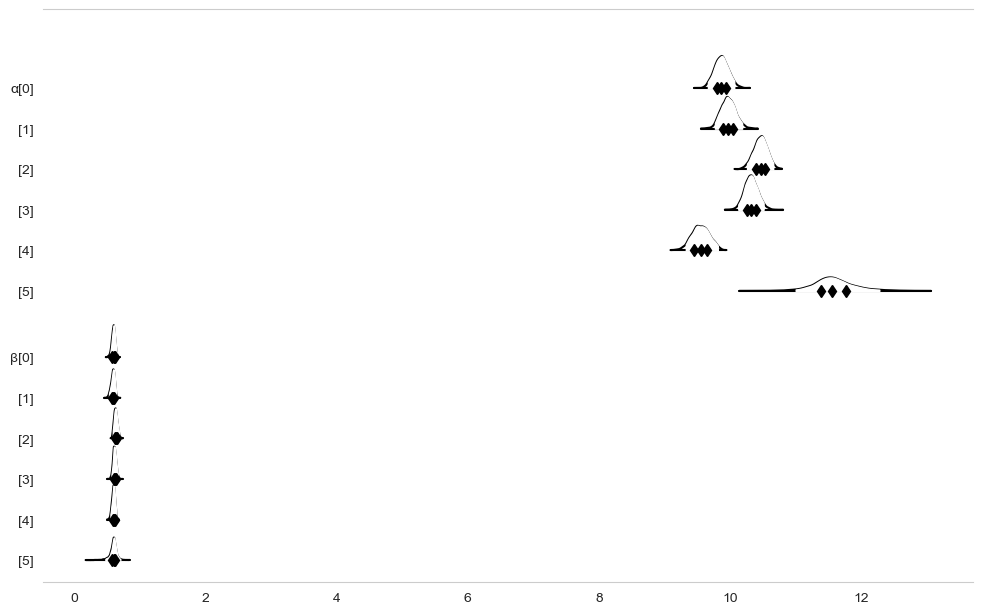

In [11]:
az.plot_forest(trace_hm, var_names=['α', 'β'],kind ='ridgeplot', 
               combined=True, 
               ridgeplot_truncate=False,
               ridgeplot_quantiles=[.25, .5, .75],
               ridgeplot_overlap=0.7,
               colors='white');

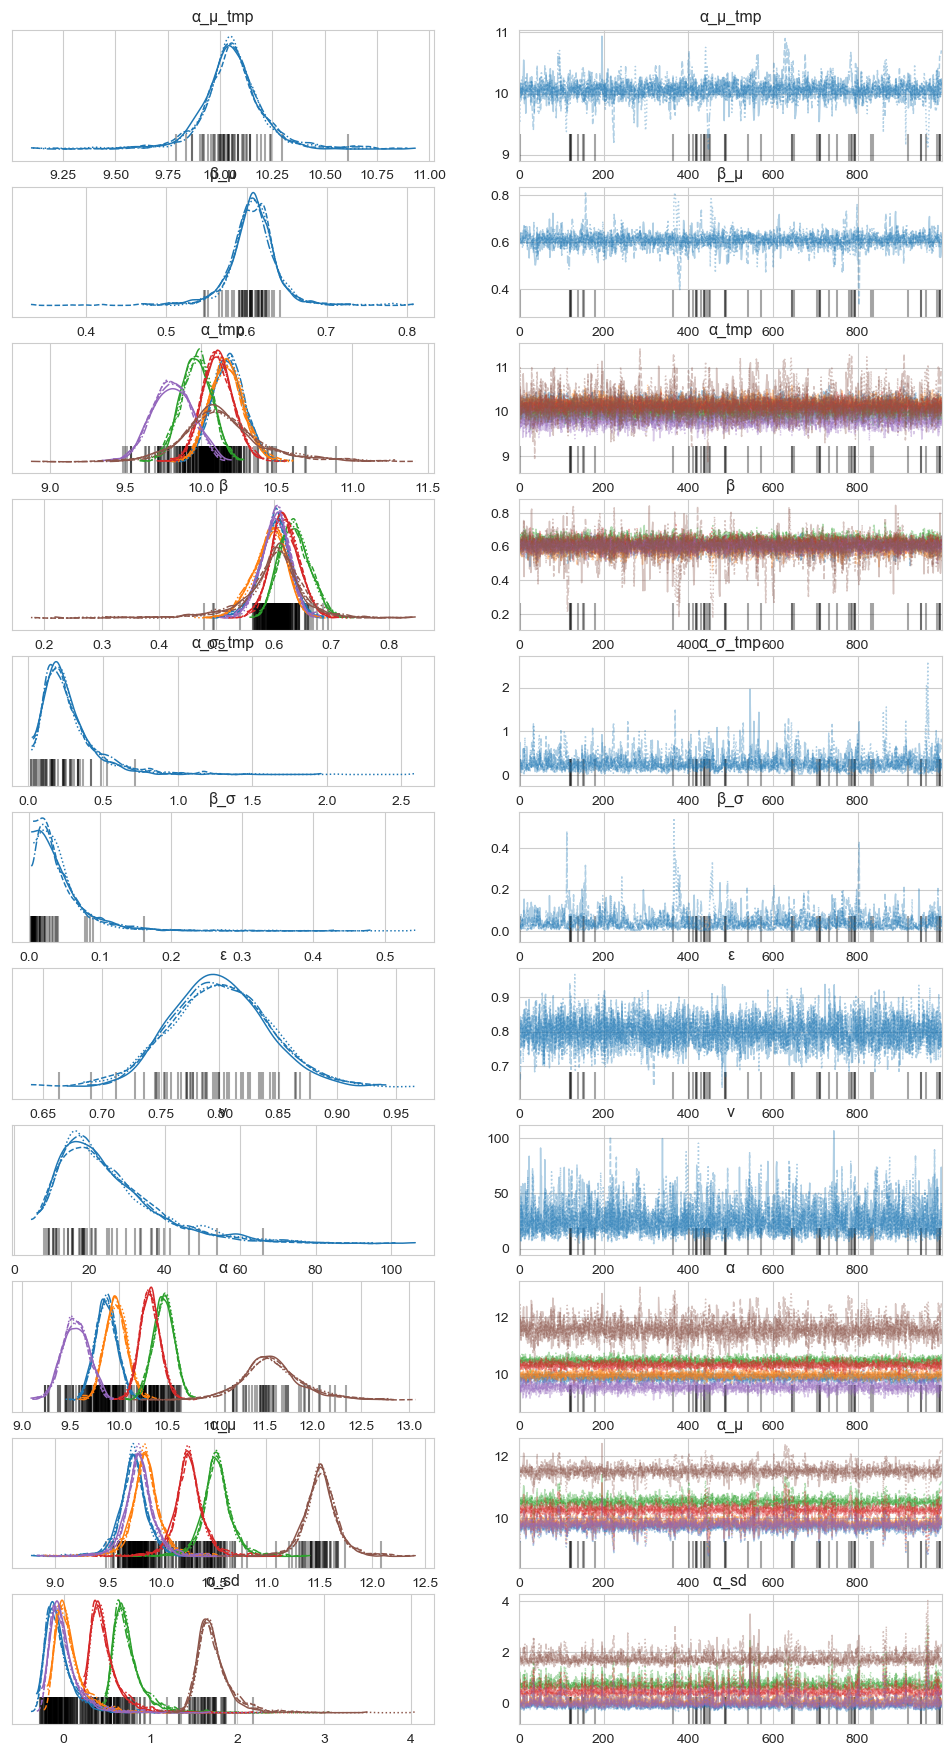

In [12]:
az.plot_trace(trace_hm);

In [13]:
trace_hm.posterior

<xarray.Dataset>
Dimensions:      (chain: 4, draw: 1000, α_tmp_dim_0: 6, β_dim_0: 6, α_dim_0: 6,
                  α_μ_dim_0: 6, α_sd_dim_0: 6)
Coordinates:
  * chain        (chain) int64 0 1 2 3
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * α_tmp_dim_0  (α_tmp_dim_0) int64 0 1 2 3 4 5
  * β_dim_0      (β_dim_0) int64 0 1 2 3 4 5
  * α_dim_0      (α_dim_0) int64 0 1 2 3 4 5
  * α_μ_dim_0    (α_μ_dim_0) int64 0 1 2 3 4 5
  * α_sd_dim_0   (α_sd_dim_0) int64 0 1 2 3 4 5
Data variables:
    α_μ_tmp      (chain, draw) float64 10.35 10.0 10.16 ... 10.04 10.24 10.0
    β_μ          (chain, draw) float64 0.6078 0.6056 0.5932 ... 0.6293 0.5874
    α_tmp        (chain, draw, α_tmp_dim_0) float64 10.21 10.26 ... 9.861 10.03
    β            (chain, draw, β_dim_0) float64 0.6246 0.5739 ... 0.5815 0.5576
    α_σ_tmp      (chain, draw) float64 0.4109 0.1661 0.7499 ... 0.2562 0.1629
    β_σ          (chain, draw) float64 0.04958 0.03822 ... 0.07207 0.02153
    ε            (chain, draw) float64 0.8393 0.8006 0.7793 ... 0.8199 0.777
    ν            (chain, draw) float64 22.92 32.64 32.48 ... 21.73 25.07 18.03
    α            (chain, draw, α_dim_0) float64 9.883 10.07 ... 9.609 11.36
    α_μ          (chain, draw, α_μ_dim_0) float64 10.04 10.15 ... 9.748 11.41
    α_sd         (chain, draw, α_sd_dim_0) float64 0.09682 0.2081 ... 1.572
Attributes:
    created_at:                 2023-11-13T15:11:32.494726
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.7.2
    sampling_time:              34.78120803833008
    tuning_steps:               1000

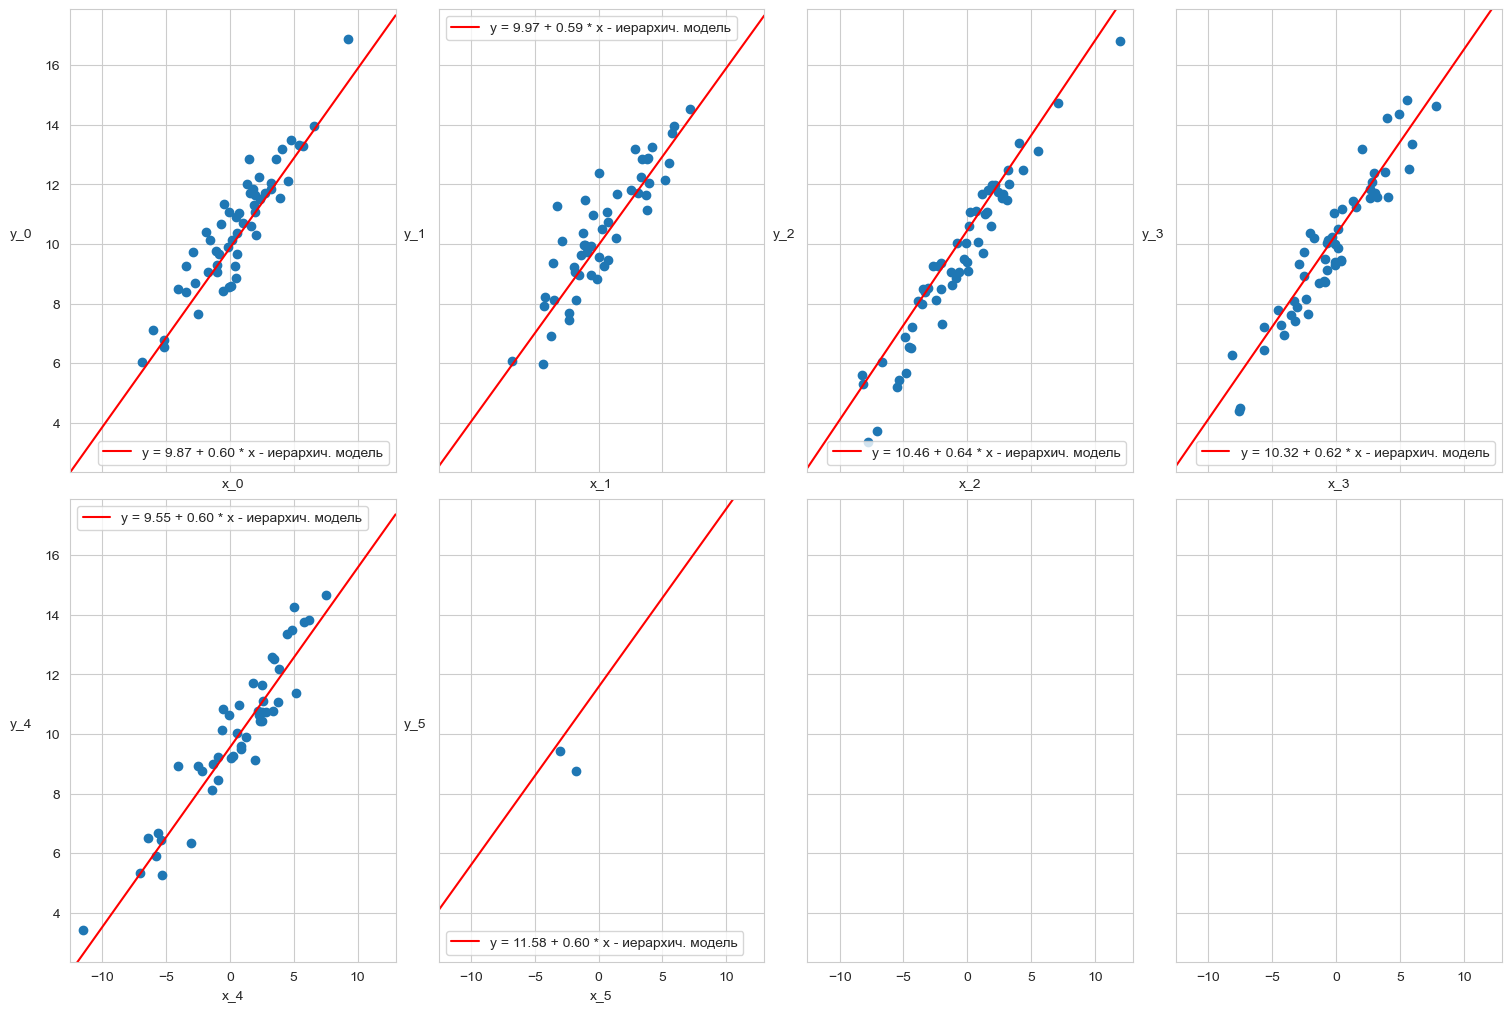

In [14]:
_, ax = plt.subplots(2, 4, figsize=(15, 10), sharex=True, sharey=True, constrained_layout=True)

# Замените trace_hmm на ваши результаты из PyMC3
trace_hmm = trace_hm.posterior.stack(samples={"chain", "draw"})

ax = np.ravel(ax)
j, k = 0, N
x_range = np.linspace(all_data['x'].min() - 1, all_data['x'].max() + 1, 10)

for i in range(M):
    ax[i].scatter(all_data[all_data['dataset_idx'] == i]['x'], all_data[all_data['dataset_idx'] == i]['y'])
    ax[i].set_xlabel(f'x_{i}')
    ax[i].set_ylabel(f'y_{i}', labelpad=17, rotation=0)
    
    # Получите средние значения параметров из трассировки
    alpha_hmm = trace_hmm['α'].sel({'α_dim_0': i}).mean().item()
    beta_hmm = trace_hmm['β'].sel({'β_dim_0': i}).mean().item()
    
    ax[i].plot(x_range, alpha_hmm + beta_hmm * x_range, c='r', label=f'y = {alpha_hmm:.2f} + {beta_hmm:.2f} * x' + ' - иерархич. модель')

    ax[i].legend()
    plt.xlim(all_data['x'].min() - 1, all_data['x'].max() + 1)
    plt.ylim(all_data['y'].min() - 1, all_data['y'].max() + 1)
    j += N
    k += N
